In [1]:
import sys, os
from pyprojroot import here


# spyder up to find the root

local = here(project_files=[".local"])

# append to path
sys.path.append(str(local))

In [2]:
import jax
import jax.numpy as jnp
import jax.random as jrandom
import numpy as np
import xarray as xr
import flax
import imageio
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm
import equinox as eqx
from einops import rearrange

from src.utils import get_meshgrid

%load_ext autoreload
%autoreload 2

In [38]:
ds_grid = xr.open_zarr("/mnt/meom/workdir/johnsonj/data/qg_data/raw/temp.nc")
img = ds_grid.p.isel(steps=slice(350,352))
img

<xarray.DataArray 'p' (steps: 2, Nx: 512, Ny: 512)>
dask.array<getitem, shape=(2, 512, 512), dtype=float64, chunksize=(2, 64, 64), chunktype=numpy.ndarray>
Coordinates:
  * Nx       (Nx) float64 -3.142 -3.129 -3.117 -3.105 ... 3.105 3.117 3.129
  * Ny       (Ny) float64 -3.142 -3.129 -3.117 -3.105 ... 3.105 3.117 3.129
  * steps    (steps) int64 350 351

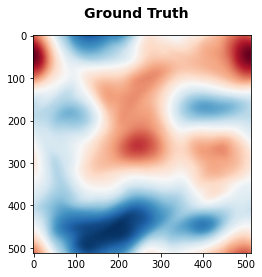

In [39]:
fig = plt.figure()
fig.suptitle('Ground Truth', fontsize=14, fontweight='bold')
plt.imshow(img[0], cmap="RdBu_r")
plt.show()

In [69]:
from sklearn.preprocessing import MinMaxScaler
# Create input pixel coordinates in the unit square

time_coords = img.coords["steps"].data
time_scaler = MinMaxScaler().fit(time_coords[:, None])
time_coords = time_scaler.transform(time_coords[:, None]).squeeze()

x_coords = img.coords["Nx"].data

coords = jnp.stack(
    np.meshgrid(
        x_coords,
        y_coords,
        time_coords
    ), -1
)


In [71]:
time_coords.min(), time_coords.max(), 

array([0., 1.])

In [52]:
img.coords["steps"].data.shape, img.coords["Ny"].data.shape

((2,), (512,))

In [47]:
coords.shape, img.shape

((512, 512, 2, 3), (2, 512, 512))

In [54]:
x = rearrange(coords, "H W T C -> (H W T) C")
y = rearrange(img.values, "T H W -> (H W T) 1")

x.shape, y.shape

((524288, 3), (524288, 1))

In [55]:
from sklearn.model_selection import train_test_split

In [56]:
# split training and testing
xtrain, xtest, ytrain, ytest = train_test_split(x, y, train_size=0.01, random_state=123)

# split training and validation
xtrain, xvalid, ytrain, yvalid = train_test_split(xtrain, ytrain, test_size=0.1, random_state=123)

In [57]:
xtrain = jnp.array(xtrain)
ytrain = jnp.array(ytrain)
xvalid = jnp.array(xvalid)
yvalid = jnp.array(yvalid)
xtest = jnp.array(xtest)
ytest = jnp.array(ytest)

print(f"# Data: {x.shape[0]:_} \n# Train: {xtrain.shape[0]:_}\n# Valid: {xvalid.shape[0]:_}\n# Test: {xtest.shape[0]:_}")

# Data: 524_288 
# Train: 4_717
# Valid: 525
# Test: 519_046


In [58]:
from src.mlp import MLPNet
from src.siren import SirenNet

init_key = jrandom.PRNGKey(123)
in_dim = 3
out_dim = 1
hidden_dim = 256
n_hidden = 5



# # SIMPLE MLP
# model = MLPNet(
#     in_dim=in_dim,
#     out_dim=out_dim,
#     hidden_dim=hidden_dim, 
#     n_hidden=n_hidden, 
#     key=init_key
# )

# SIREN MODEL
w0_initial = 30.0
w0 = 1.0
final_scale = 1.0

model = SirenNet(
    in_dim=in_dim,
    out_dim=out_dim,
    hidden_dim=hidden_dim, 
    n_hidden=n_hidden,
    w0=w0,
    w0_initial=w0_initial,
    final_scale=final_scale,
    key=init_key
)


In [59]:
model

SirenNet(
  layers=[
    Siren(weight=f32[256,3], bias=f32[256], w0=30.0, activation=Sine(w0=30.0)),
    Siren(weight=f32[256,256], bias=f32[256], w0=1.0, activation=Sine(w0=1.0)),
    Siren(weight=f32[256,256], bias=f32[256], w0=1.0, activation=Sine(w0=1.0)),
    Siren(weight=f32[256,256], bias=f32[256], w0=1.0, activation=Sine(w0=1.0)),
    Siren(weight=f32[256,256], bias=f32[256], w0=1.0, activation=Sine(w0=1.0)),
    Siren(weight=f32[256,256], bias=f32[256], w0=1.0, activation=Sine(w0=1.0)),
    Siren(weight=f32[1,256], bias=f32[1], w0=1.0, activation=Identity())
  ],
  w0=1.0,
  final_scale=1.0,
  final_activation=Identity()
)

In [60]:
init_batch = xtrain[:100]
init_out = ytrain[:100]

out = jax.vmap(model)(init_batch)

# check sizes
assert out.shape == init_out.shape

In [61]:
out.shape, init_out.shape

((100, 1), (100, 1))

In [62]:
import optax

learning_rate = 1e-4

optim = optax.adam(learning_rate)
opt_state = optim.init(model)

In [63]:
@eqx.filter_jit
@eqx.filter_value_and_grad
def make_step(model, x, y):
    pred_y = jax.vmap(model)(x)
    # Trains with respect to binary cross-entropy
    return jnp.mean((pred_y - y)**2)

@eqx.filter_jit
def val_step(model, x, y):
    pred_y = jax.vmap(model)(x)
    # Trains with respect to binary cross-entropy
    return jnp.mean((pred_y - y)**2)
    

In [64]:
# loss, grads = make_step(model, xtrain[idx], ytrain[idx])
# perm = jrandom.permutation(key, indices)

In [65]:
import tensorflow.data as tfd
import typing as tp

def make_mini_batcher(
     X, y,
     batch_size: tp.Optional[int] = 32,
     prefetch_buffer: tp.Optional[int] = 1,
 ) -> tp.Iterator:

    n = X.shape[0]

    batch_size = min(batch_size, n)

    # Make dataloader, set batch size and prefetch buffer:
    ds = tfd.Dataset.from_tensor_slices((X, y))
    ds = ds.cache()
    ds = ds.repeat()
    ds = ds.shuffle(n)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(prefetch_buffer)

    # Make iterator:
    train_iter = iter(ds)

    # Batch loader:
    def next_batch():
        x_batch, y_batch = train_iter.next()
        return jnp.asarray(x_batch.numpy()), jnp.asarray(y_batch.numpy())

    return next_batch

In [66]:
batch_size = 64
steps = 2_000

# keys for the permutations
# loader_key = jrandom.PRNGKey(42)
# indices = jnp.arange(x.shape[0])
# perm = jrandom.split(loader_key, steps)
ds_iter = make_mini_batcher(xtrain, ytrain, 32, 1)

losses = {} 
losses["train"] = []
losses["valid"] = []


with tqdm.trange(steps) as pbar:
    for step in pbar:
        
        # idx = jrandom.choice(perm[step], indices, shape=(batch_size,))
        # loss, grads = make_step(model, xtrain[idx], ytrain[idx])
        
        ix, iy = ds_iter()
        loss, grads = make_step(model, ix, iy)
        
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        
        losses["train"].append(loss)
        
        # validation step
        vloss = val_step(model, xvalid, yvalid)
        losses["valid"].append(vloss)

        pbar.set_description(f"Step: {step} | Train Loss: {loss:.4f} | Valid Loss: {vloss:.4f}")

  0%|          | 0/2000 [00:00<?, ?it/s]

KeyboardInterrupt: 

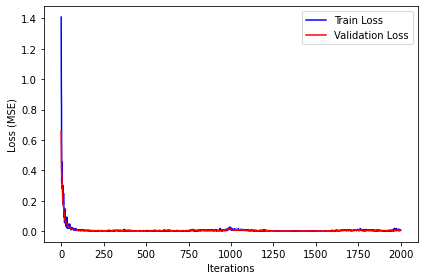

In [20]:
fig, ax = plt.subplots()

ax.plot(losses["train"], label="Train Loss", color="blue")
ax.plot(losses["valid"], label="Validation Loss", color="red")
ax.set(xlabel="Iterations", ylabel="Loss (MSE)", yscale="linear")
plt.tight_layout()
plt.legend()
plt.show()

In [21]:
outputs = jax.vmap(model)(x)

In [22]:
img_pred = rearrange(outputs, " (H W) 1 -> H W 1", H=coords.shape[0], W=coords.shape[1])

## Results

In [23]:
import pandas as pd

In [24]:
def create_da(coords, data, name="full_pred"):
    
    return pd.DataFrame(np.hstack([coords, data]), columns=["Nx", "Ny", name]).set_index(["Nx", "Ny"]).to_xarray()

def create_mask(coords, name="train", factor=1):
    return create_da(coords, factor * np.ones((coords.shape[0],1)), name=name)

In [25]:
# create data arrays
pred_true = create_da(x, y, "true")

# full predictions
outputs = jax.vmap(model)(x)
pred_full = create_da(x, outputs, "pred")



In [26]:
# create masked arrays
mask_train = create_mask(xtrain, "train", 0)
mask_valid = create_mask(xvalid, "valid", 1)
mask_test = create_mask(xtest, "test", 2)

mask = xr.merge([mask_train, mask_valid, mask_test], compat='override')

mask["mask"] = 1 * np.ones((mask.dims["Nx"], mask.dims["Ny"])) * np.isfinite(mask.train)
mask["mask"] += 2 * np.ones((mask.dims["Nx"], mask.dims["Ny"])) * np.isfinite(mask.valid)
mask["mask"] += 3 * np.ones((mask.dims["Nx"], mask.dims["Ny"])) * np.isfinite(mask.test)

In [27]:
mask

<xarray.Dataset>
Dimensions:  (Nx: 512, Ny: 512)
Coordinates:
  * Nx       (Nx) float64 -3.142 -3.129 -3.117 -3.105 ... 3.105 3.117 3.129
  * Ny       (Ny) float64 -3.142 -3.129 -3.117 -3.105 ... 3.105 3.117 3.129
Data variables:
    train    (Nx, Ny) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    valid    (Nx, Ny) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    test     (Nx, Ny) float64 2.0 2.0 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0 2.0
    mask     (Nx, Ny) float64 3.0 3.0 3.0 3.0 3.0 3.0 ... 3.0 3.0 3.0 3.0 3.0

In [28]:
ds = xr.merge([pred_true, pred_full], compat='override')
ds

<xarray.Dataset>
Dimensions:  (Nx: 512, Ny: 512)
Coordinates:
  * Nx       (Nx) float64 -3.142 -3.129 -3.117 -3.105 ... 3.105 3.117 3.129
  * Ny       (Ny) float64 -3.142 -3.129 -3.117 -3.105 ... 3.105 3.117 3.129
Data variables:
    true     (Nx, Ny) float64 1.099 1.12 1.142 1.164 ... 1.033 1.052 1.071 1.091
    pred     (Nx, Ny) float32 1.155 1.174 1.193 1.212 ... 0.9912 1.001 1.01

In [29]:
ds.coords["mask"] = mask["mask"]

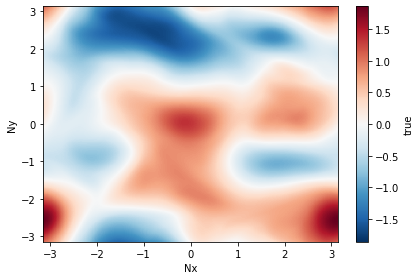

In [30]:
fig, ax = plt.subplots()

ds.true.T.plot(ax=ax, )

plt.tight_layout()
plt.show()

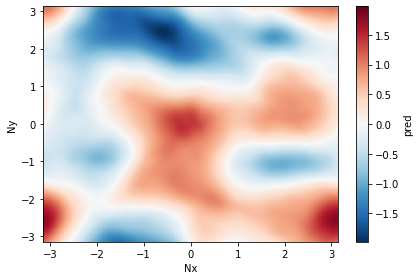

In [31]:
fig, ax = plt.subplots()

ds.pred.T.plot(ax=ax, )

plt.tight_layout()
plt.show()

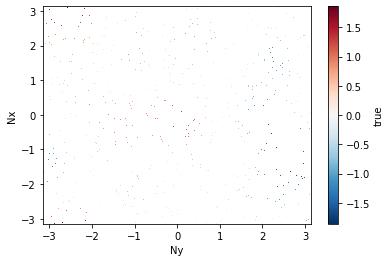

In [32]:
ds.true.where(ds.mask == 1).plot()

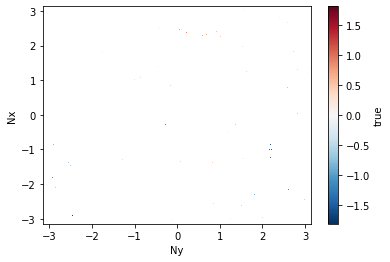

In [33]:
ds.true.where(ds.mask==2).plot()

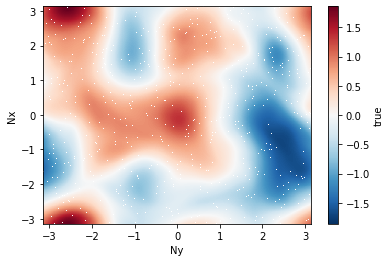

In [34]:
ds.true.where(ds.mask==3).plot()

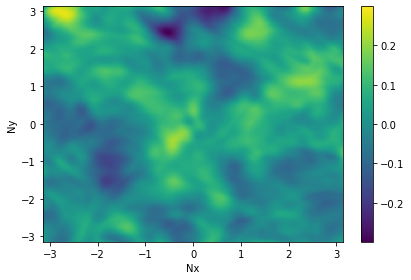

In [35]:
fig, ax = plt.subplots()

(ds.pred.T - ds.true.T).plot(ax=ax, cmap="viridis")

plt.tight_layout()
plt.show()